In [1]:
import pandas as pd
import os
from scipy.stats import norm
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import sys
sys.path.insert(0,'../src/data')
sys.path.insert(0,'../src/modules')
import load_pose_data
import skvideo.io
import itertools
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.linalg import svd

def plot_skel(df, vid, frame,ax,xvar,yvar):
    alpha =.7
    df = df[(df.frame==frame)].reset_index(drop=True)
    for i,limb in enumerate(limbSeq):
        l1 = limb[0]-1; l2 = limb[1]-1;
        if (len(df[df.part_idx==l1])>0) & (len(df[df.part_idx==l2])>0):
            ax.plot([df[df.part_idx==l1][xvar].iloc[0],df[df.part_idx==l2][xvar].iloc[0]], [df[df.part_idx==l1][yvar].iloc[0],df[df.part_idx==l2][yvar].iloc[0]],linewidth=5, color=[j/255 for j in colors[i]], alpha=alpha)
    # plot kp
    for i in range(len(df)):
        ax.plot(df[xvar][i],df[yvar][i], 'o',markersize = 10, color=[j/255 for j in colors[i]], alpha=alpha)

        
def gen_one_frame(df, vid, frame,dpi):
    fig=plt.figure(dpi=dpi)
    canvas = FigureCanvas(fig)
    ax = plt.gca()
    
    plot_skel(df, vid, i, ax, 'x', 'y')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-3,3)
    ax.set_ylim(-1,2)
    ax.invert_yaxis()
    ax.axis('off')
    canvas.draw()
    width, height = fig.get_size_inches() * fig.get_dpi()
    im = np.fromstring(canvas.tostring_rgb(), dtype='uint8')
    im = im.reshape(int(height), int(width), 3)
    plt.close()
    return im

def get_one_frame(video,f1):
    videogen = skvideo.io.vreader(video)
    new_videogen = itertools.islice(videogen, f1, f1+1, 1)
    for image in new_videogen:
        a = 1
    return image

def normm(df):
    df['Value'] = (df['Value'] - df['Value'].mean())/df['Value'].std()
    return df

colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0],
          [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255],
          [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85],[255, 0, 0]]

limbSeq = [[2, 3], [2, 6], [3, 4], [4, 5], [6, 7], [7, 8], [2, 9], [9, 10], \
           [10, 11], [2, 12], [12, 13], [13, 14], [2, 1], [1, 15], [15, 17], \
           [1, 16], [16, 18], [3, 17], [6, 18]]


In [2]:
path = '../data/processed/'

surprise = pd.read_pickle(os.path.join(path, 'bayes_surprise.pkl'))
features = pd.read_pickle(os.path.join(path, 'final_feature_set.pkl'))

# We will include the following features computed from the positions of the extremities (wrists/ankles) and joint angles (elbows/knees):
# - absolute position/angle
# - variability of position/angle
# - median speed
# - variability of speed
# - median absolute velocity
# - variability of velocity
# - variability of acceleration
# - measure of complexity (entropy)
# - measure of symmetry (left-right cross correlation)

# 'Elbow_stdev_angle'
feature_list = ['Wrist_mediandist','Ankle_mediandist','Elbow_mean_angle', 'Knee_mean_angle',\
                'Wrist_IQRdist','Ankle_IQRdist','Elbow_stdev_angle', 'Knee_stdev_angle',\
                'Wrist_medianspeed','Ankle_medianspeed',\
                'Wrist_IQRspeed','Ankle_IQRspeed',\
                'Wrist_medianvel','Ankle_medianvel','Elbow_median_vel_angle','Knee_median_vel_angle',\
                'Wrist_IQRvel','Ankle_IQRvel', 'Elbow_IQR_vel_angle', 'Knee_IQR_vel_angle',\
                'Wrist_IQRacc', 'Ankle_IQRacc', 'Elbow_IQR_acc_angle','Knee_IQR_acc_angle',\
                'Wrist_meanent', 'Ankle_meanent', 'Elbow_entropy_angle', 'Knee_entropy_angle',\
                'Wrist_lrCorr_x','Ankle_lrCorr_x', 'Elbow_lrCorr_angle', 'Knee_lrCorr_angle']
                
labels_list = ['Median wrist position','Median ankle position','Mean elbow angle','Mean knee angle',\
'IQR wrist position', 'IQR ankle position', 'Stdev. elbow angle','Stdev. knee angle',\
'Median wrist speed','Median ankle speed', 'IQR wrist speed','IQR ankle speed',\
'Median wrist velocity','Median ankle velocity' ,'Median elbow angular velocity', 'Median knee angular velocity',\
'IQR wrist velocity','IQR ankle velocity','IQR elbow angular velocity','IQR knee angular velocity',\
'IQR wrist acceleration','IQR ankle acceleration','IQR elbow angular acceleration','IQR knee angular acceleration',\
'Entropy wrist position', 'Entropy ankle position','Entropy elbow angle', 'Entropy knee angle',\
'Cross-correlation wrist position', 'Cross-correlation ankle position','Cross-correlation elbow angle','Cross-correlation knee angle']

labels_list_feature = ['Median position (l)','Median position (l)','Mean angle (deg.)','Mean angle (deg.)',\
'IQR position (l)', 'IQR position (l)', 'Stdev. angle (deg.)','Stdev. angle (deg.)',\
'Median speed (l/s)','Median speed (l/s)', 'IQR speed (l/s)','IQR speed (l/s)',\
'Median velocity (l/s)','Median velocity (l/s)' ,'Median angular velocity (deg./s)', 'Median angular velocity (deg./s)',\
'IQR velocity (l/s)','IQR velocity (l/s)','IQR angular velocity (l/s)','IQR angular velocity (l/s)',\
'IQR acceleration (l/s\u00b2)','IQR acceleration (l/s\u00b2)','IQR angular acceleration (l/s\u00b2)','IQR angular acceleration (l/s\u00b2)',\
'Entropy position', 'Entropy position','Entropy angle', 'Entropy angle',\
'Cross-correlation position', 'Cross-correlation position','Cross-correlation angle','Cross-correlation angle']

labels_list_feature_2 = ['Med. position','Med. position','Mean angle','Mean angle',\
'IQR position', 'IQR position', 'Stdev. angle','Stdev. angle',\
'Med. speed','Med. speed', 'IQR speed','IQR speed',\
'Med. velocity','Med. velocity' ,'Med. angular velocity', 'Med. angular velocity',\
'IQR velocity','IQR velocity','IQR angular velocity','IQR angular velocity',\
'IQR acceleration','IQR acceleration','IQR angular acceleration','IQR angular acceleration',\
'Entropy position', 'Entropy position','Entropy angle', 'Entropy angle',\
'Cross-correlation position', 'Cross-correlation position','Cross-correlation angle','Cross-correlation angle']


labels_list_feature_3 = ['Med wrist pos','Med ankle pos','Mean elbow angle','Mean knee angle',\
'IQR wrist pos', 'IQR ankle pos', 'Stdev. elbow angle','Stdev. knee angle',\
'Med wrist speed','Med ankle speed', 'IQR wrist speed','IQR ankle speed',\
'Med wrist vel','Med ankle vel' ,'Med elbow angle vel', 'Med knee angle vel',\
'IQR wrist vel','IQR ankle vel','IQR elbow angle vel','IQR knee angle vel',\
'IQR wrist accel','IQR ankle accel','IQR elbow angle accel','IQR knee angle accel',\
'Entropy wrist pos', 'Entropy ankle pos','Entropy elbow angle', 'Entropy knee angle',\
'Cross-corr wrist pos', 'Cross-corr ankle pos','Cross-corr elbow angle','Cross-corr knee angle']

labels_list_part =  ['Wrist','Ankle','Elbow','Knee',\
'Wrist', 'Ankle', 'Elbow','Knee',\
'Wrist', 'Ankle', 'Wrist', 'Ankle',\
'Wrist', 'Ankle', 'Elbow','Knee',\
'Wrist', 'Ankle', 'Elbow','Knee',\
'Wrist', 'Ankle', 'Elbow','Knee',\
'Wrist', 'Ankle', 'Elbow','Knee',\
'Wrist', 'Ankle', 'Elbow','Knee']

labels_list_part =  ['Wrist','Ankle','Elbow','Knee',\
'Wrist', 'Ankle', 'Elbow','Knee',\
'Wrist', 'Ankle', 'Wrist', 'Ankle',\
'Wrist', 'Ankle', 'Elbow','Knee',\
'Wrist', 'Ankle', 'Elbow','Knee',\
'Wrist', 'Ankle', 'Elbow','Knee',\
'Wrist', 'Ankle', 'Elbow','Knee',\
'Wrist', 'Ankle', 'Elbow','Knee']

feature_label_df = pd.DataFrame.from_dict({'feature':feature_list, 'feature_label':labels_list_feature,'feature_label_2':labels_list_feature_2,'feature_label_3':labels_list_feature_3,'part_label':labels_list_part, 'full_feature_label':labels_list})
features = pd.merge(features, feature_label_df, on='feature', how='outer')


features_norm = features.groupby('feature').apply(normm).reset_index()

feature_table = pd.pivot_table(features_norm, values='Value', index=['infant','risk'], columns=['feature','feature_label_3'])

# SVD
A = feature_table.values
U, s, VT = svd(A)
m = A.shape[0]
n = A.shape[1]
sing_val = np.zeros(A.shape, int)
np.fill_diagonal(sing_val, s)

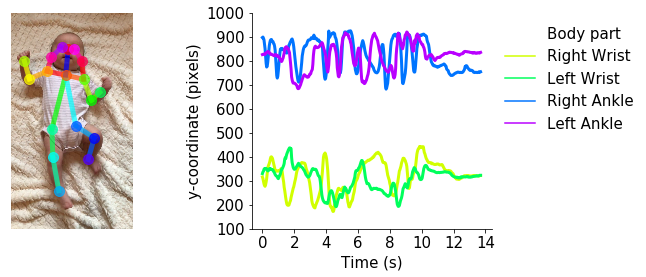

In [3]:
# visualize openpose output
fontsize=15
data_set = 'example_video'
path = '../data/example_video'
pose_path = '../data/pose_estimates/example_video/py/pose_estimates.pkl'

load_pose_data.main(data_set, path)

df = pd.read_pickle(pose_path)
vid = 'video_exampl'
vidpath = os.path.join(path,vid+'.mov')
frame1 = 55
framen = 56
frame_interval = 1
xvar = 'x'
yvar = 'y'

fig,axs=plt.subplots(nrows=1,ncols=2, figsize=(10,5))
ax = axs[0]
img = get_one_frame(vidpath,framen)
ax.imshow(img)
for i in np.arange(frame1,framen,frame_interval):
    plot_skel(df[df.frame==i], vid, i, ax, xvar,yvar)
ax.set_aspect('equal', adjustable='box')
ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax = axs[1]
df = df[np.isin(df.bp, ['LAnkle', 'RAnkle', 'LWrist', 'RWrist'])]
df.loc[df.bp=='LAnkle','bp'] = 'Left Ankle'
df.loc[df.bp=='RAnkle','bp'] = 'Right Ankle'
df.loc[df.bp=='LWrist','bp'] = 'Left Wrist'
df.loc[df.bp=='RWrist','bp'] = 'Right Wrist'
df['Body part'] = df['bp']
df['time'] = df['frame']/30
sns.lineplot(x='time', y='y', hue='Body part', data=df, ax = ax, palette="hsv", linewidth=3)
ax.set_xlabel('Time (s)',fontsize=fontsize)
ax.set_ylabel('y-coordinate (pixels)',fontsize=fontsize)
ax.set_yticks(np.arange(100,1100, step=100))
ax.set_yticklabels(np.arange(100,1100, step=100),fontsize=fontsize)
ax.set_xticks(np.arange(0,16, step=2))
ax.set_xticklabels(np.arange(0,16, step=2),fontsize=fontsize)
ax.legend(bbox_to_anchor=(1,1), frameon=False,fontsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# sns.despine()
fig.subplots_adjust(left=.05, bottom=.2, right=.8, top=.8, wspace=.25, hspace=.2)
fig.savefig('../data/visualization/pose_estimates.pdf') 

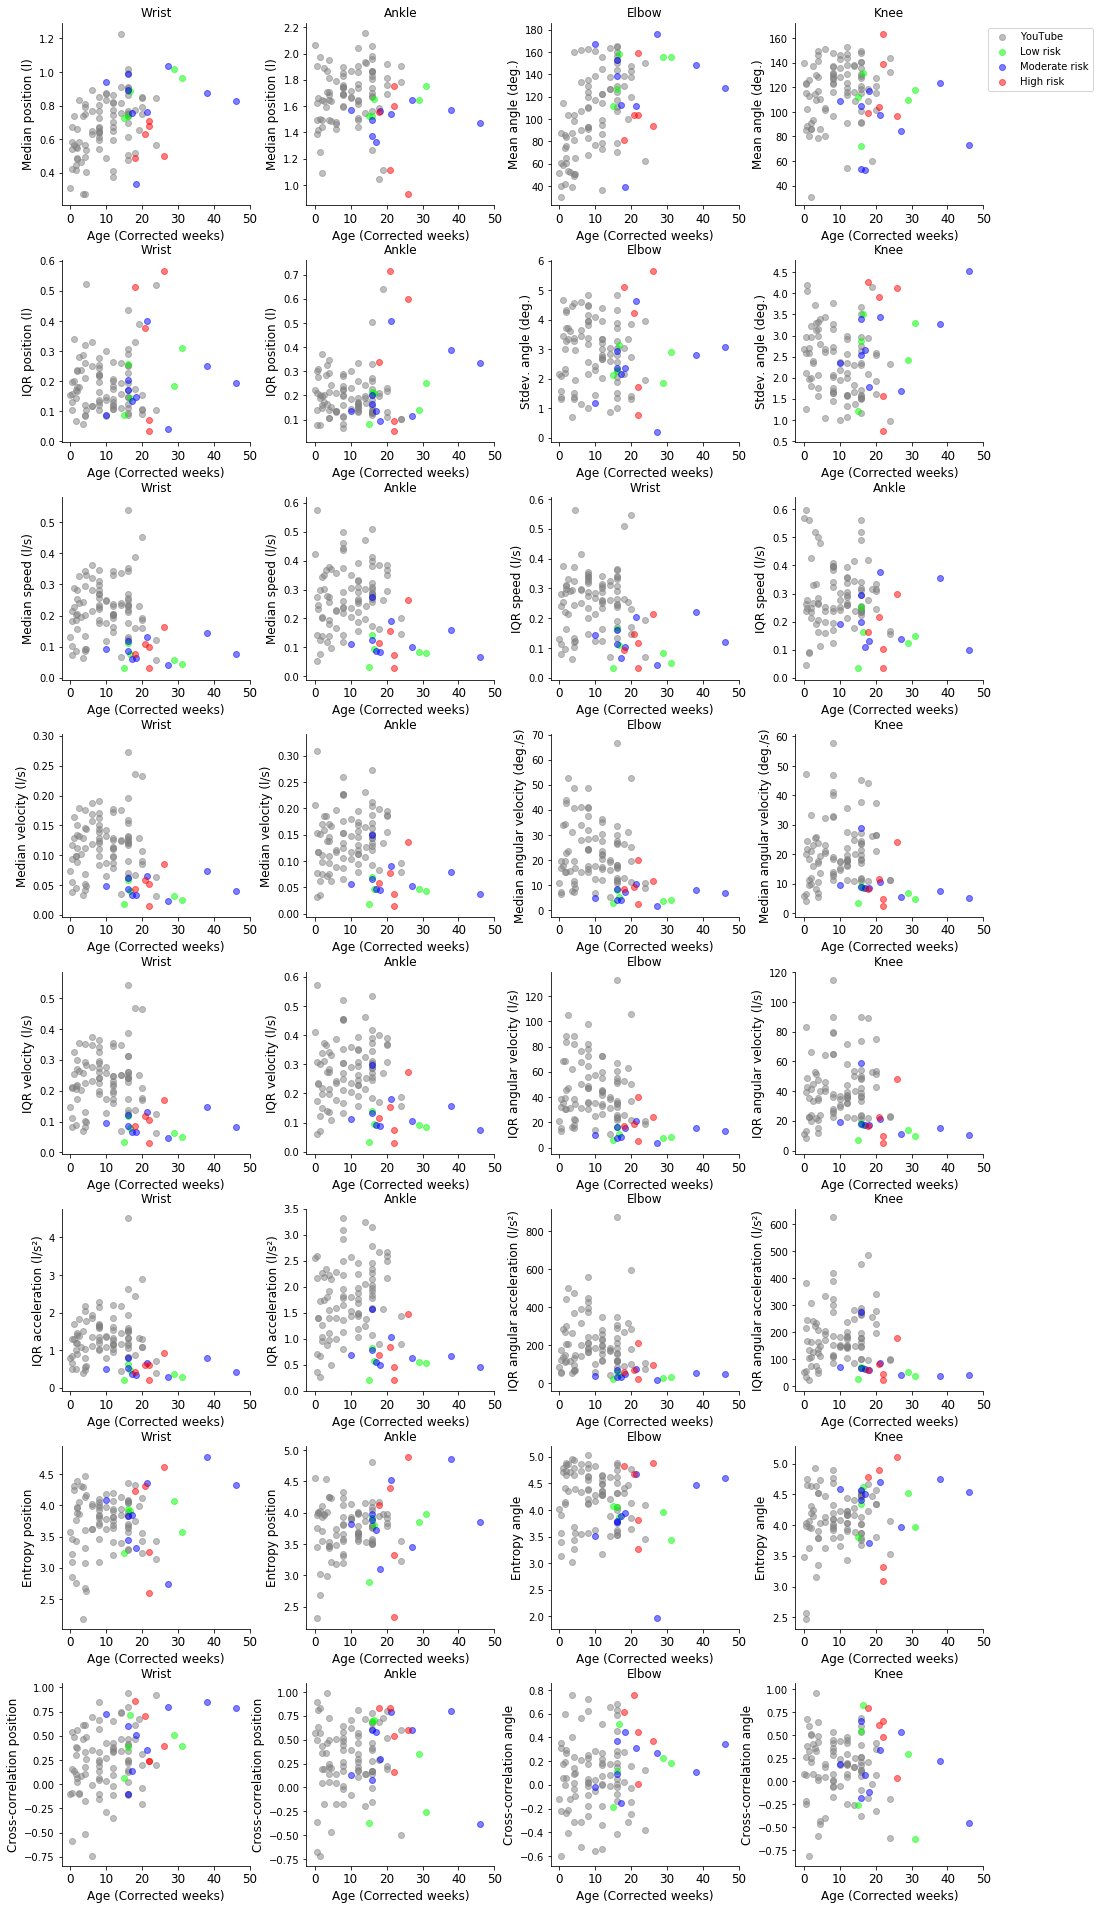

In [10]:
# plot features x age x risk
fontsize = 12
nrow = 8
ncol = 4
s = 4

fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(4*s, 8*s))
for i, icol in enumerate(feature_list):
    
    ax = axs.flat[i]
#     ax.text(xlabel, ylabel, labelz[i], transform=ax.transAxes,fontsize=fontsize_label, va='top', ha='right')
    sns.regplot(data=features[(features.risk==0)&(features.feature==icol)], x='age_in_weeks', y = 'Value', ax = ax, fit_reg=False, color=[.5,.5,.5], scatter_kws={'alpha':0.5},label='YouTube')
    sns.regplot(data=features[(features.risk==1)&(features.feature==icol)], x='age_in_weeks', y = 'Value', ax = ax, fit_reg=False, color=[0,1,0], scatter_kws={'alpha':0.5},label='Low risk')
    sns.regplot(data=features[(features.risk==2)&(features.feature==icol)], x='age_in_weeks', y = 'Value', ax = ax, fit_reg=False, color=[0,0,1], scatter_kws={'alpha':0.5},label='Moderate risk')
    sns.regplot(data=features[(features.risk==3)&(features.feature==icol)], x='age_in_weeks', y = 'Value', ax = ax, fit_reg=False, color=[1,0,0], scatter_kws={'alpha':0.5},label='High risk')
    if i==3:
        ax.legend(bbox_to_anchor=(1,1))
    
    ax.set_ylabel(labels_list_feature[i],fontsize=fontsize)
    ax.set_title(labels_list_part[i],fontsize=fontsize)
    ax.set_xlabel('Age (Corrected weeks)',fontsize=fontsize)
    ax.set_xticks(np.arange(0,60,step=10))
    ax.set_xticklabels(np.arange(0,60,step=10), fontsize=fontsize)
fig.subplots_adjust(left=.1, bottom=.1, right=.9, top=.9, wspace=.3, hspace=.3) 
sns.despine()

fig.savefig('../data/visualization/features.pdf') 

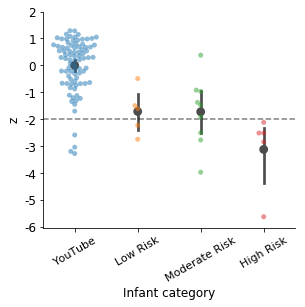

In [5]:
# bayes surprise by group

fig,ax=plt.subplots(nrows=1,ncols=1, figsize=(5,5))

sns.swarmplot(ax=ax,x="risk", y="z", data=surprise, alpha=.5, dodge=True,zorder=100)
sns.pointplot(ax=ax,x="risk", y="z", data=surprise, join=False, color=[.3,.3,.3],zorder=-1, estimator=np.mean)

ax.plot([-.5,6], [-2]*2, alpha=.5,color=[0,0,0], ls='--')
ax.set_ylabel('z', fontsize=fontsize)
ax.set_xticks(np.arange(4))
ax.set_xticklabels(['YouTube', 'Low Risk', 'Moderate Risk', 'High Risk'],fontsize=fontsize-1,rotation=30)
ax.set_yticks(np.arange(-6,3))
ax.set_yticklabels(np.arange(-6,3),fontsize=fontsize)

ax.set_xlabel('Infant category',fontsize=fontsize)
sns.despine()

fig.subplots_adjust(left=.2, bottom=.3, right=.9, top=.9, wspace=.2, hspace=.2)
fig.savefig('../data/visualization/bayes_surprise.pdf') 

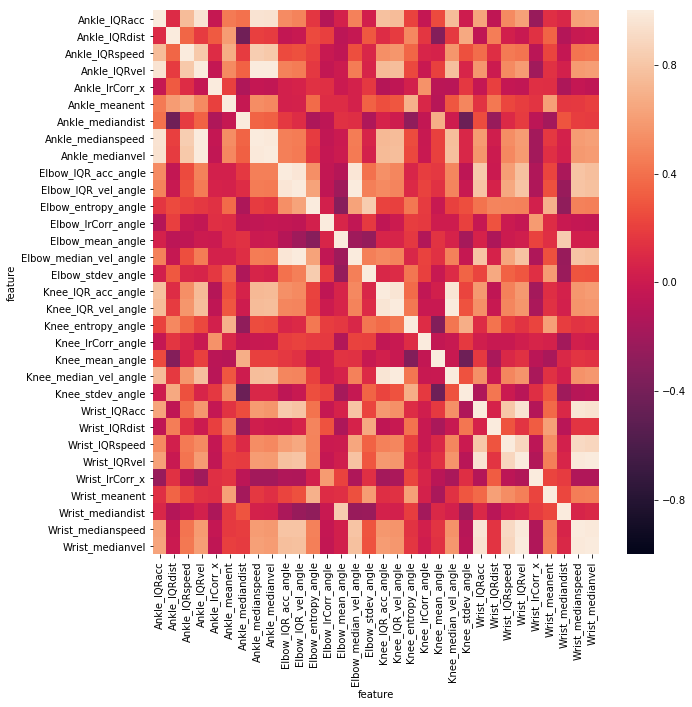

In [6]:
# correlation across features
a = pd.pivot_table(features, index=['infant', 'risk'], columns=['feature'])['Value'].reset_index()
a = a.drop('risk', axis=1)

fig, ax = plt.subplots(ncols = 1,nrows=1, figsize=(10,10))
sns.heatmap(a.corr(), vmin=-1, vmax = 1,ax=ax)
plt.show()

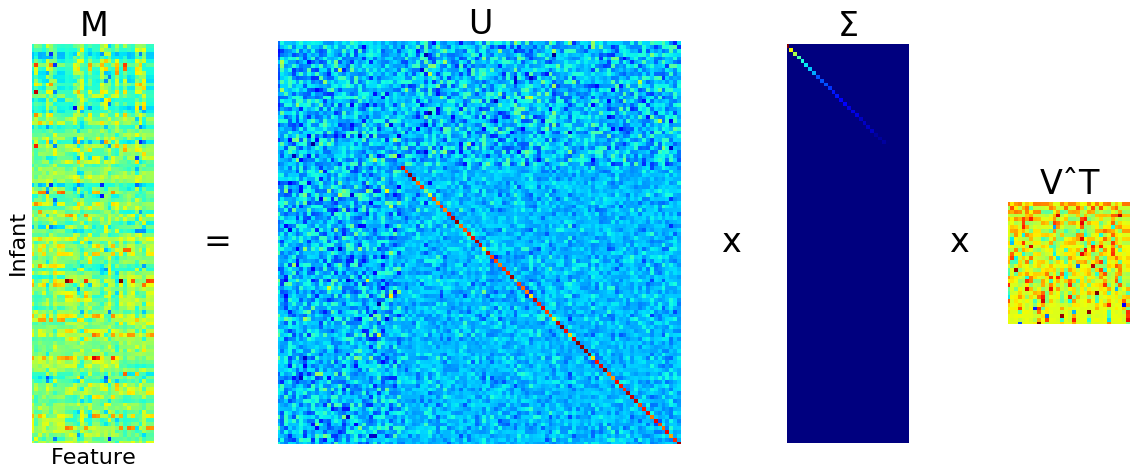

In [7]:
# SVD matrices

fontsize=20
title_fontsize = 30

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(30, 20), dpi=80)
ax[0].imshow(np.flipud(A), cmap='jet',vmin=-5,vmax=5,origin='upper')
ax[0].set_ylim(0,m)
ax[0].set_xlim(0,n)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].set_ylabel('Infant',fontsize=fontsize)
ax[0].set_xlabel('Feature',fontsize=fontsize)
ax[0].set_title('M', fontsize=title_fontsize)

ax[0].text(1.5, .5, '=', transform=ax[0].transAxes,fontsize=title_fontsize, va='center', ha='center')


ax[1].imshow(np.flipud(U), cmap='jet',vmin=-.4,vmax=.9,origin='upper')
ax[1].set_ylim(0,m)
ax[1].set_xlim(0,m)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].set_title('U', fontsize=title_fontsize)

ax[1].text(1.12, .5, 'x', transform=ax[1].transAxes,fontsize=title_fontsize, va='center', ha='center')


im = ax[2].imshow(np.flipud(sing_val), cmap='jet',vmin=0,vmax=34,origin='upper')
ax[2].set_ylim(0,m)
ax[2].set_xlim(0,n)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].spines['right'].set_visible(False)
ax[2].spines['left'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].spines['bottom'].set_visible(False)
ax[2].set_title('\u03A3', fontsize=title_fontsize)

ax[2].text(1.4, .5, 'x', transform=ax[2].transAxes,fontsize=title_fontsize, va='center', ha='center')


ax[3].imshow(np.flipud(VT), cmap='jet',vmin=-1,vmax=.6,origin='upper')
ax[3].set_xlim(0,n)
ax[3].set_ylim(0,n)
ax[3].set_xticks([])
ax[3].set_yticks([])
ax[3].spines['right'].set_visible(False)
ax[3].spines['left'].set_visible(False)
ax[3].spines['top'].set_visible(False)
ax[3].spines['bottom'].set_visible(False)
ax[3].set_title('$\mathregular{VˆT}$', fontsize=title_fontsize)

pos0 = ax[0].get_position().bounds
pos1 = ax[1].get_position().bounds
pos2 = ax[2].get_position().bounds
pos3 = ax[3].get_position().bounds
newpos0 = [pos0[0]+.1,pos0[1],pos1[2]/105*32,pos1[3]]
ax[0].set_position(newpos0)
newpos2 = [pos2[0]+.01,pos2[1],pos1[2]/105*32,pos1[3]]
ax[2].set_position(newpos2)
newpos3 = [pos3[0]-.1,pos3[1]+.25,pos1[2]/105*32,pos1[3]/105*32]
ax[3].set_position(newpos3)

fig.savefig('../data/visualization/svd_matrices.pdf') 

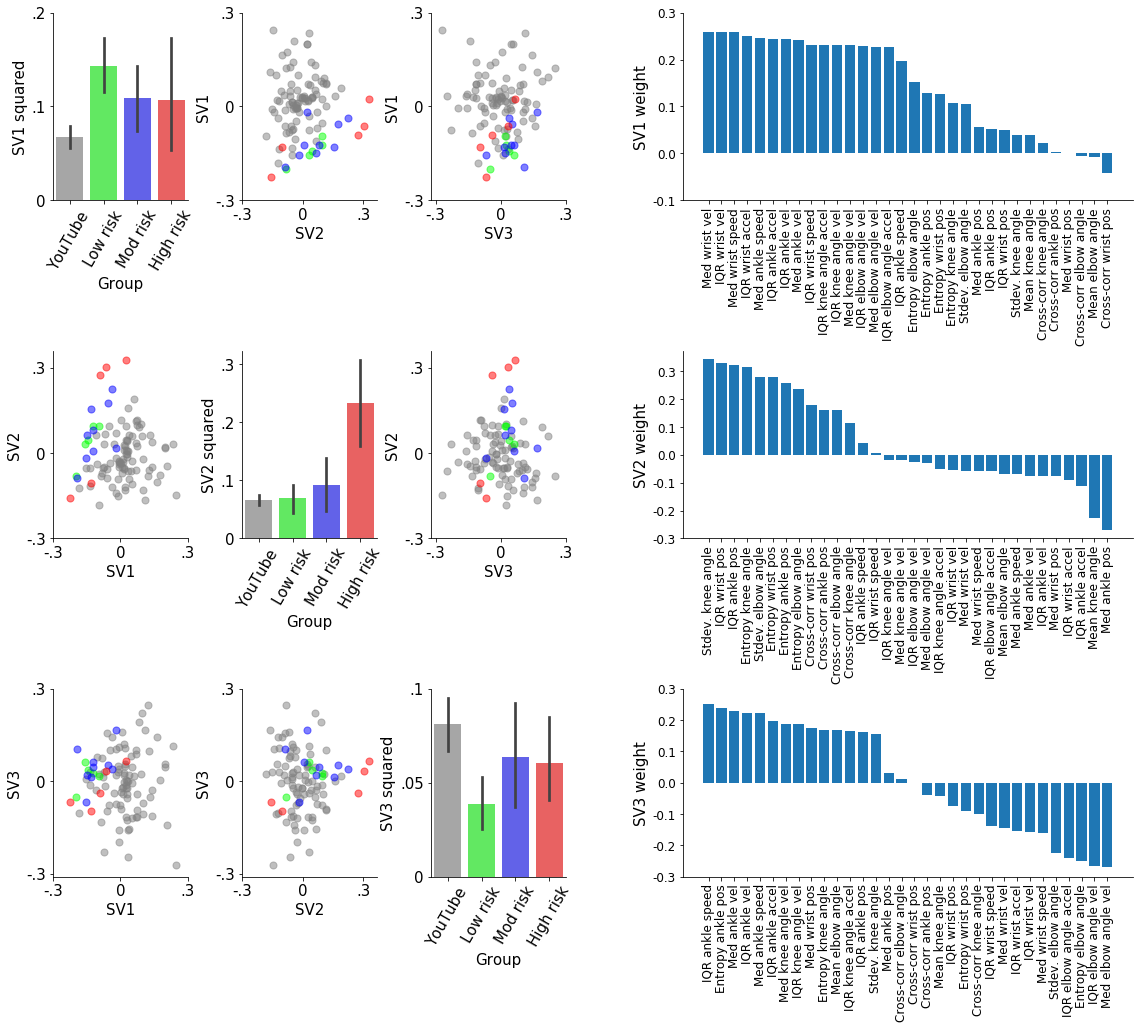

In [11]:
# SVD analysis

rotation=90
fontsize_label = 12
fontsize = 15
size=50

p = pd.DataFrame.from_dict({'vt1':VT[0],'vt2':VT[1],'vt3':VT[2],'feature':feature_table.columns.levels[1][feature_table.columns.labels[1]]})
sv = pd.DataFrame.from_dict({'risk':np.array(feature_table.reset_index().risk), 'sv1': U[:,0], 'sv2': U[:,1],'sv3': U[:,2]})
sv_centered = np.sqrt((sv[['sv1','sv2','sv3']]-sv[['sv1','sv2','sv3']].mean())**2)
sv_centered['risk'] = sv['risk']



fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(3,6,1)
sns.barplot(data = sv_centered, x='risk', y='sv1',ax=ax,alpha=.7, palette=[[.5,.5,.5],[0,1,0],[0,0,1],[1,0,0]])
ax.set_xlabel('Group',fontsize=fontsize)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['YouTube','Low risk','Mod risk','High risk'], rotation=60,fontsize=fontsize)
ax.set_ylabel('SV1 squared',fontsize=fontsize)
ax.set_yticks([0,.1,.2])
ax.set_yticklabels(['0','.1','.2'],fontsize=fontsize)

ax = fig.add_subplot(3,6,2)
sns.regplot(data=sv[sv.risk==0], x='sv2', y = 'sv1', ax = ax, fit_reg=False, color=[.5,.5,.5], scatter_kws={'alpha':0.5,'s':size},label='YouTube')
sns.regplot(data=sv[sv.risk==1], x='sv2', y = 'sv1', ax = ax, fit_reg=False, color=[0,1,0], scatter_kws={'alpha':0.5,'s':size},label='Low risk')
sns.regplot(data=sv[sv.risk==2], x='sv2', y = 'sv1', ax = ax, fit_reg=False, color=[0,0,1], scatter_kws={'alpha':0.5,'s':size},label='Moderate risk')
sns.regplot(data=sv[sv.risk==3], x='sv2', y = 'sv1', ax = ax, fit_reg=False, color=[1,0,0], scatter_kws={'alpha':0.5,'s':size},label='High risk')
ax.set_xlabel('SV2',fontsize=fontsize)
ax.set_xticks([-.3,0,.3])
ax.set_xticklabels(['-.3','0','.3'],fontsize=fontsize)
ax.set_ylabel('SV1',fontsize=fontsize)
ax.set_yticks([-.3,0,.3])
ax.set_yticklabels(['-.3','0','.3'],fontsize=fontsize)

ax = fig.add_subplot(3,6,3)
sns.regplot(data=sv[sv.risk==0], x='sv3', y = 'sv1', ax = ax, fit_reg=False, color=[.5,.5,.5], scatter_kws={'alpha':0.5,'s':size},label='YouTube')
sns.regplot(data=sv[sv.risk==1], x='sv3', y = 'sv1', ax = ax, fit_reg=False, color=[0,1,0], scatter_kws={'alpha':0.5,'s':size},label='Low risk')
sns.regplot(data=sv[sv.risk==2], x='sv3', y = 'sv1', ax = ax, fit_reg=False, color=[0,0,1], scatter_kws={'alpha':0.5,'s':size},label='Moderate risk')
sns.regplot(data=sv[sv.risk==3], x='sv3', y = 'sv1', ax = ax, fit_reg=False, color=[1,0,0], scatter_kws={'alpha':0.5,'s':size},label='High risk')
ax.set_xlabel('SV3',fontsize=fontsize)
ax.set_xticks([-.3,0,.3])
ax.set_xticklabels(['-.3','0','.3'],fontsize=fontsize)
ax.set_ylabel('SV1',fontsize=fontsize)
ax.set_yticks([-.3,0,.3])
ax.set_yticklabels(['-.3','0','.3'],fontsize=fontsize)

ax = fig.add_subplot(3,2,2)
p1 = p.sort_values(by='vt1',ascending=False)
ax.bar(np.arange(len(VT)),p1.vt1)
ax.set_xticks(np.arange(len(VT)))
ax.set_xticklabels(labels = p1.feature,rotation=rotation,fontsize = fontsize_label)
ax.set_yticks(np.arange(-.1,.4,.1))
ax.set_yticklabels(labels = np.around(np.arange(-.1,.4,.1),decimals=1),fontsize = fontsize_label)
ax.set_ylabel('SV1 weight',fontsize=fontsize)

ax = fig.add_subplot(3,6,7)
sns.regplot(data=sv[sv.risk==0], x='sv1', y = 'sv2', ax = ax, fit_reg=False, color=[.5,.5,.5], scatter_kws={'alpha':0.5,'s':size},label='YouTube')
sns.regplot(data=sv[sv.risk==1], x='sv1', y = 'sv2', ax = ax, fit_reg=False, color=[0,1,0], scatter_kws={'alpha':0.5,'s':size},label='Low risk')
sns.regplot(data=sv[sv.risk==2], x='sv1', y = 'sv2', ax = ax, fit_reg=False, color=[0,0,1], scatter_kws={'alpha':0.5,'s':size},label='Moderate risk')
sns.regplot(data=sv[sv.risk==3], x='sv1', y = 'sv2', ax = ax, fit_reg=False, color=[1,0,0], scatter_kws={'alpha':0.5,'s':size},label='High risk')
ax.set_xlabel('SV1',fontsize=fontsize)
ax.set_xticks([-.3,0,.3])
ax.set_xticklabels(['-.3','0','.3'],fontsize=fontsize)
ax.set_ylabel('SV2',fontsize=fontsize)
ax.set_yticks([-.3,0,.3])
ax.set_yticklabels(['-.3','0','.3'],fontsize=fontsize)

ax = fig.add_subplot(3,6,8) 
sns.barplot(data = sv_centered, x='risk', y='sv2',ax=ax, alpha=.7, palette=[[.5,.5,.5],[0,1,0],[0,0,1],[1,0,0]])
ax.set_xlabel('Group',fontsize=fontsize)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['YouTube','Low risk','Mod risk','High risk'], rotation=60,fontsize=fontsize)
ax.set_ylabel('SV2 squared',fontsize=fontsize)
ax.set_yticks([0,.1,.2,.3])
ax.set_yticklabels(['0','.1','.2','.3'],fontsize=fontsize)


ax = fig.add_subplot(3,6,9)
sns.regplot(data=sv[sv.risk==0], x='sv3', y = 'sv2', ax = ax, fit_reg=False, color=[.5,.5,.5], scatter_kws={'alpha':0.5,'s':size},label='YouTube')
sns.regplot(data=sv[sv.risk==1], x='sv3', y = 'sv2', ax = ax, fit_reg=False, color=[0,1,0], scatter_kws={'alpha':0.5,'s':size},label='Low risk')
sns.regplot(data=sv[sv.risk==2], x='sv3', y = 'sv2', ax = ax, fit_reg=False, color=[0,0,1], scatter_kws={'alpha':0.5,'s':size},label='Moderate risk')
sns.regplot(data=sv[sv.risk==3], x='sv3', y = 'sv2', ax = ax, fit_reg=False, color=[1,0,0], scatter_kws={'alpha':0.5,'s':size},label='High risk')
ax.set_xlabel('SV3',fontsize=fontsize)
ax.set_xticks([-.3,0,.3])
ax.set_xticklabels(['-.3','0','.3'],fontsize=fontsize)
ax.set_ylabel('SV2',fontsize=fontsize)
ax.set_yticks([-.3,0,.3])
ax.set_yticklabels(['-.3','0','.3'],fontsize=fontsize)

ax = fig.add_subplot(3,2,4)
p1 = p.sort_values(by='vt2',ascending=False)
ax.bar(np.arange(len(VT)),p1.vt2)
ax.set_xticks(np.arange(len(VT)))
ax.set_xticklabels(labels = p1.feature,rotation=rotation,fontsize = fontsize_label)
ax.set_yticks(np.arange(-.3,.4,.1))
ax.set_yticklabels(labels = np.around(np.arange(-.3,.4,.1),decimals=1),fontsize = fontsize_label)
ax.set_ylabel('SV2 weight',fontsize=fontsize)

ax = fig.add_subplot(3,6,13)
sns.regplot(data=sv[sv.risk==0], x='sv1', y = 'sv3', ax = ax, fit_reg=False, color=[.5,.5,.5], scatter_kws={'alpha':0.5,'s':size},label='YouTube')
sns.regplot(data=sv[sv.risk==1], x='sv1', y = 'sv3', ax = ax, fit_reg=False, color=[0,1,0], scatter_kws={'alpha':0.5,'s':size},label='Low risk')
sns.regplot(data=sv[sv.risk==2], x='sv1', y = 'sv3', ax = ax, fit_reg=False, color=[0,0,1], scatter_kws={'alpha':0.5,'s':size},label='Moderate risk')
sns.regplot(data=sv[sv.risk==3], x='sv1', y = 'sv3', ax = ax, fit_reg=False, color=[1,0,0], scatter_kws={'alpha':0.5,'s':size},label='High risk')
ax.set_xlabel('SV1',fontsize=fontsize)
ax.set_xticks([-.3,0,.3])
ax.set_xticklabels(['-.3','0','.3'],fontsize=fontsize)
ax.set_ylabel('SV3',fontsize=fontsize)
ax.set_yticks([-.3,0,.3])
ax.set_yticklabels(['-.3','0','.3'],fontsize=fontsize)

ax = fig.add_subplot(3,6,14) 
sns.regplot(data=sv[sv.risk==0], x='sv2', y = 'sv3', ax = ax, fit_reg=False, color=[.5,.5,.5], scatter_kws={'alpha':0.5,'s':size},label='YouTube')
sns.regplot(data=sv[sv.risk==1], x='sv2', y = 'sv3', ax = ax, fit_reg=False, color=[0,1,0], scatter_kws={'alpha':0.5,'s':size},label='Low risk')
sns.regplot(data=sv[sv.risk==2], x='sv2', y = 'sv3', ax = ax, fit_reg=False, color=[0,0,1], scatter_kws={'alpha':0.5,'s':size},label='Moderate risk')
sns.regplot(data=sv[sv.risk==3], x='sv2', y = 'sv3', ax = ax, fit_reg=False, color=[1,0,0], scatter_kws={'alpha':0.5,'s':size},label='High risk')
ax.set_xlabel('SV2',fontsize=fontsize)
ax.set_xticks([-.3,0,.3])
ax.set_xticklabels(['-.3','0','.3'],fontsize=fontsize)
ax.set_ylabel('SV3',fontsize=fontsize)
ax.set_yticks([-.3,0,.3])
ax.set_yticklabels(['-.3','0','.3'],fontsize=fontsize)

ax = fig.add_subplot(3,6,15) 
sns.barplot(data = sv_centered, x='risk', y='sv3',ax=ax, alpha=.7, palette=[[.5,.5,.5],[0,1,0],[0,0,1],[1,0,0]])
ax.set_xlabel('Group',fontsize=fontsize)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['YouTube','Low risk','Mod risk','High risk'], rotation=60,fontsize=fontsize)
ax.set_ylabel('SV3 squared',fontsize=fontsize)
ax.set_yticks([0,.05,.1])
ax.set_yticklabels(['0','.05','.1'],fontsize=fontsize)

ax = fig.add_subplot(3,2,6)
p1 = p.sort_values(by='vt3',ascending=False)
ax.bar(np.arange(len(VT)),p1.vt3)
ax.set_xticks(np.arange(len(VT)))
ax.set_xticklabels(labels = p1.feature,rotation=rotation,fontsize = fontsize_label)
ax.set_yticks(np.arange(-.3,.4,.1))
ax.set_yticklabels(labels = np.around(np.arange(-.3,.4,.1),decimals=1),fontsize = fontsize_label)
ax.set_ylabel('SV3 weight',fontsize=fontsize)

sns.despine()
fig.subplots_adjust(left=.05, bottom=.2, right=.8, top=.8, wspace=.4, hspace=.8)

fig.savefig('../data/visualization/svd_analysis.pdf') 
